In [1]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Assignment

In [3]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

In [4]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife\bald_eagle
oregon_wildlife\black_bear
oregon_wildlife\cougar
oregon_wildlife\deer
oregon_wildlife\nutria
oregon_wildlife\raccoon
oregon_wildlife\raven
oregon_wildlife\red_fox
oregon_wildlife\sea_lions
oregon_wildlife\virginia_opossum

total img num: 7168


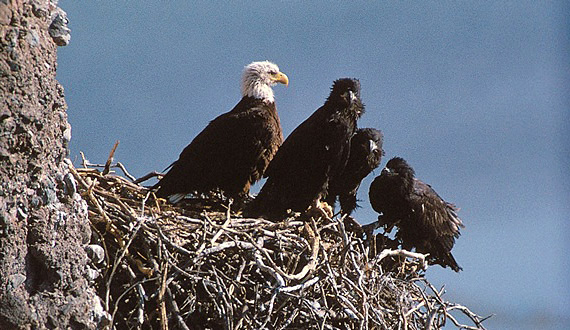

oregon_wildlife\bald_eagle\ef53500091a17787a2.jpg
bald_eagle


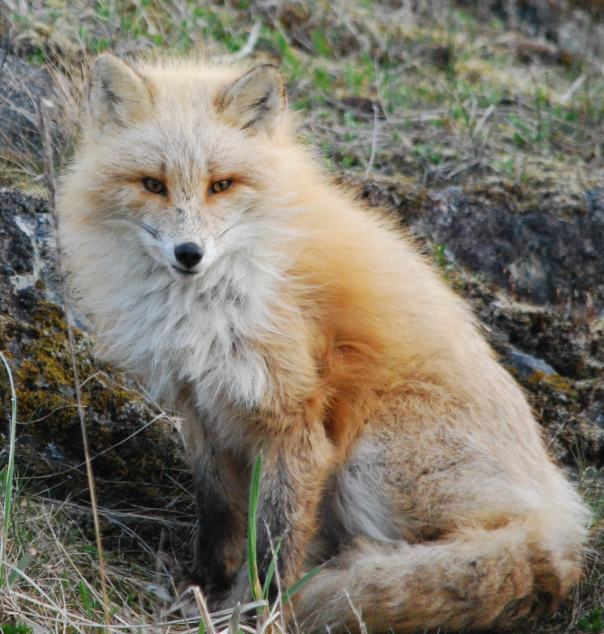

oregon_wildlife\red_fox\fd1c53b82304571e77.jpg
red_fox


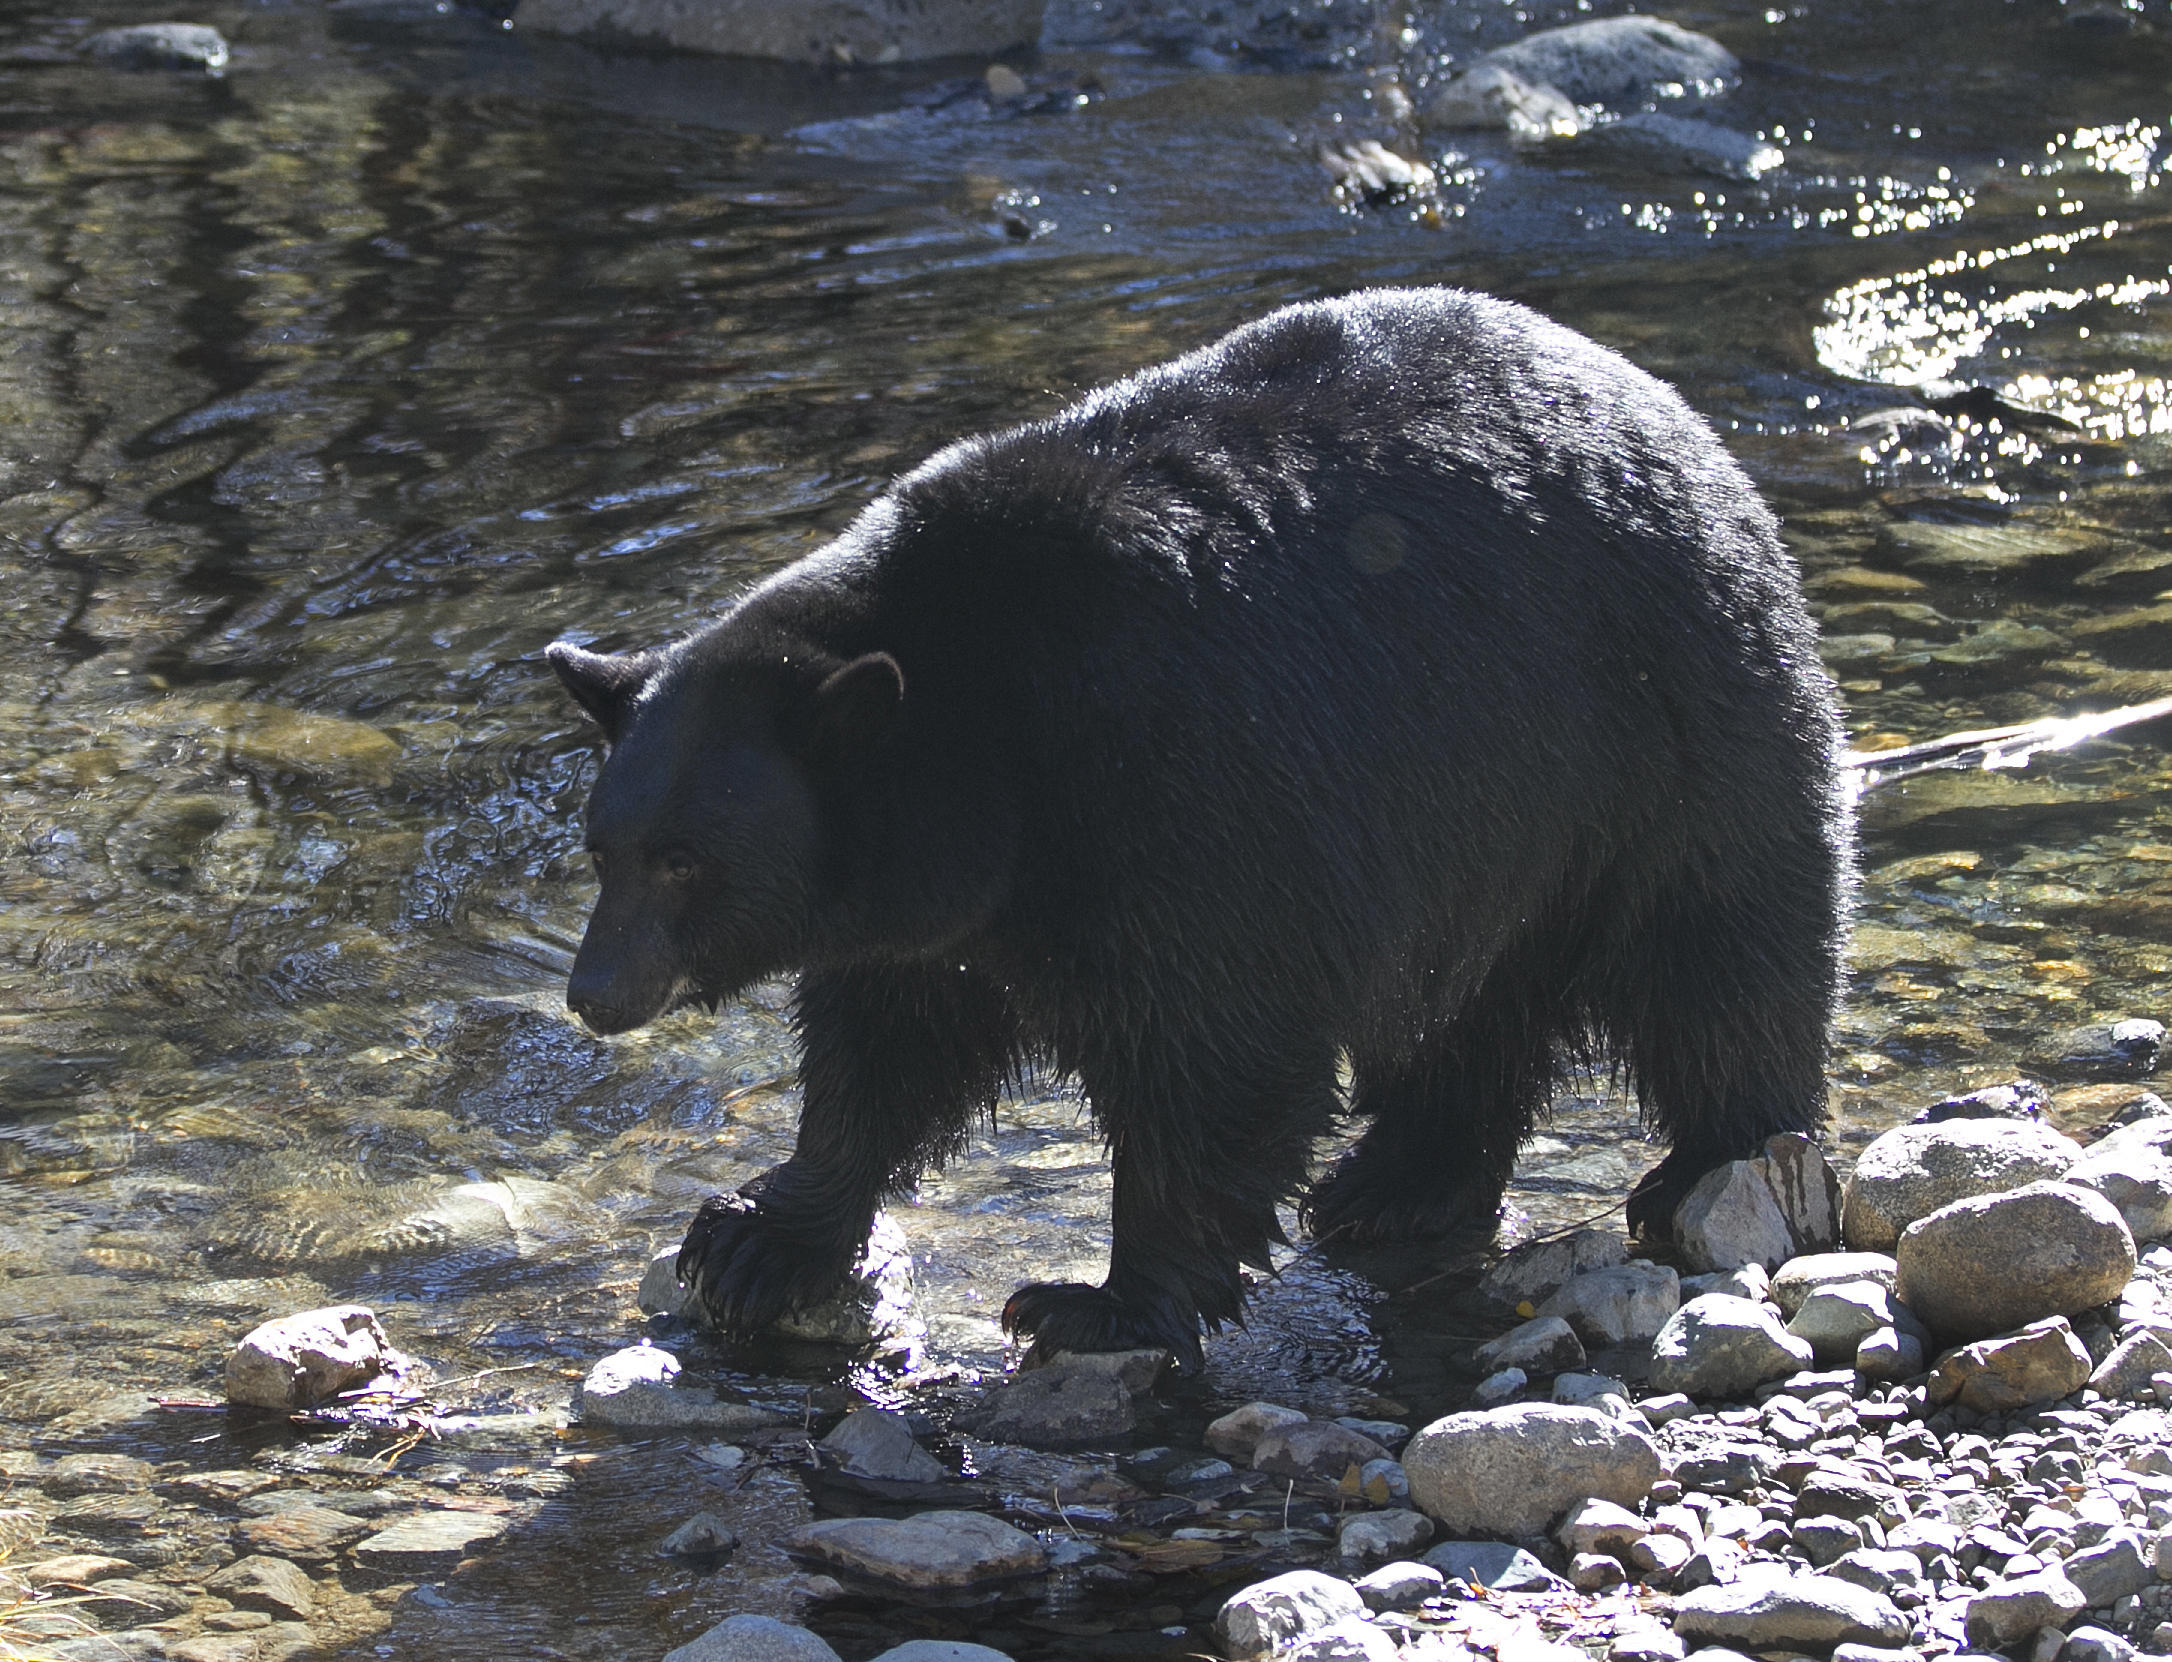

oregon_wildlife\black_bear\59997972db9965f569.jpg
black_bear


In [3]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path)
    #Windows \
    print(image_path.split('\\')[-2])

In [5]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [6]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [7]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [8]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [9]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('val.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_val, label_val):
        writer.writerow([img_path, label])

In [10]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [11]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

In [12]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string),
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32),
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )


    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        
        rows = pd.read_csv(filename.decode("utf-8"))
        img_paths = rows['img_path'].tolist()
        labels = rows['label'].tolist()
        
        open_elapsed = time.perf_counter() - open_enter

        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = load_image(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                labels[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [13]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 16

def dataset_generator_fun_train(*args):
    filename = 'train.csv'
    return TimeMeasuredDataset(filename)

def dataset_generator_fun_val(*args):
    return TimeMeasuredDataset('val.csv')

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_val).batch(BATCH_SIZE)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[7.531328e+01 2.400490e-02]
 [7.533728e+01 2.661890e-02]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


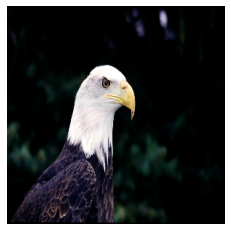

bald_eagle


In [15]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [14]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [15]:
wild_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [16]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [17]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [18]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = wild_model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def val_step(images, labels):
    predictions = wild_model(images, training=False)
    v_loss = loss_object(labels, predictions)

    val_loss(v_loss)
    val_accuracy(labels, predictions)

In [19]:
def timelined_benchmark(dataset_train, dataset_test):
    EPOCHS = 3

    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        print("training:")
        for steps, times, values, images, labels in tqdm(dataset_train, total=math.ceil(len(img_path_train)/BATCH_SIZE)):
            for i in range(steps.shape[0]):
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            train_enter = time.perf_counter()
            train_step(images, labels)
            train_elapsed = time.perf_counter() - train_enter

            for i in range(steps.shape[0]):        
                steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
                times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        print("validating:")
        for steps, times, values, images, labels in tqdm(dataset_test, total=math.ceil(len(img_path_val)/BATCH_SIZE)):
            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            val_enter = time.perf_counter()
            val_step(images, labels)
            val_elapsed = time.perf_counter() - val_enter

            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, [["Val"]]), axis=0)
                times_acc = tf.concat((times_acc, [(val_enter, val_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, val Loss: {:.4f}, val Accuracy: {:.4f}'
        print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               val_loss.result(),
                               val_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch, -1]]), axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [25]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()

    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)

    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)

    order = [b'Open', b'Read', b'Map', b'Train', b'Val', b'Test', b'Epoch']
    step_ids = sorted(step_ids, key=lambda i: order.index(i))
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")

        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]

        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

In [22]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_val)

training:


100%|██████████████████████████████████████████████████████████████████████████████| 5734/5734 [04:48<00:00, 19.91it/s]


validating:


100%|██████████████████████████████████████████████████████████████████████████████| 1434/1434 [00:42<00:00, 33.38it/s]


Epoch 1, Loss: 4.6203, Accuracy: 10.7778, val Loss: 2.2957, val Accuracy: 11.5063
training:


100%|██████████████████████████████████████████████████████████████████████████████| 5734/5734 [04:40<00:00, 20.44it/s]


validating:


100%|██████████████████████████████████████████████████████████████████████████████| 1434/1434 [00:42<00:00, 33.37it/s]


Epoch 2, Loss: 3.0688, Accuracy: 10.8476, val Loss: 2.3298, val Accuracy: 10.6695
training:


100%|██████████████████████████████████████████████████████████████████████████████| 5734/5734 [04:42<00:00, 20.28it/s]


validating:


100%|██████████████████████████████████████████████████████████████████████████████| 1434/1434 [00:43<00:00, 32.91it/s]

Epoch 3, Loss: 2.5394, Accuracy: 10.6732, val Loss: 2.2984, val Accuracy: 10.3905
Execution time: 980.8920426


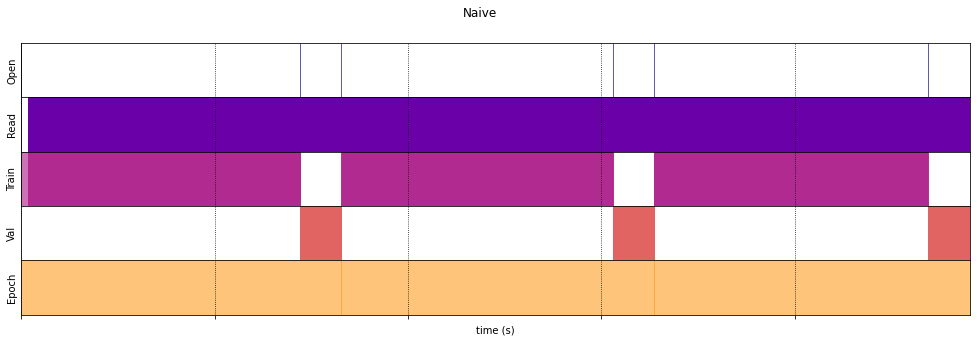

In [25]:
draw_timeline(timeline_Naive, "Naive", 500)

## Try some the input transfromation mentioned above (e.g. shuffle, batch, repeat, map(random_crop, random_flip_left_right, ...)) but without optimization terms (e.g. prefetch, cache, num_parallel_calls), comparing the performance to the no input transfromation.

In [20]:
def dataset_map_train(steps, times, values, img, label):
    #distorted_img = tf.image.random_crop(img, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    map_enter = time.perf_counter()
    distorted_img = tf.image.random_flip_left_right(img)
    distorted_img = tf.image.random_brightness(distorted_img, max_delta=63)
    distorted_img = tf.image.random_contrast(
    distorted_img, lower=0.2, upper=1.8)
    distorted_img = tf.image.per_image_standardization(distorted_img)
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_img,\
           label

def dataset_map_val(steps, times, values, img, label):
    map_enter = time.perf_counter()
    #distorted_img = tf.image.random_flip_left_right(img)
    #distorted_img = tf.image.random_brightness(distorted_img, max_delta=63)
    #distorted_img = tf.image.random_contrast(
    #distorted_img, lower=0.2, upper=1.8)
    distorted_img = tf.image.per_image_standardization(img)
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_img,\
           label

In [21]:
#dataset_train_augmentation = dataset_train.map(dataset_map_train)
#dataset_val_augmentation = dataset_val.map(dataset_map_val)
BUFFER_SIZE = 10000
BATCH_SIZE = 16
PEPEAT_COUNT=2

In [22]:
dataset_train_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                        .shuffle(BUFFER_SIZE)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .repeat(PEPEAT_COUNT)\
                                        .map(dataset_map_train)

dataset_test_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_val)\
                                       .batch(BATCH_SIZE, drop_remainder=True)\
                                       .map(dataset_map_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[b'Open']
 [b'Read']
 [b'Map']], shape=(3, 1), dtype=string) tf.Tensor(
[[-1.0000000e+00 -1.0000000e+00]
 [ 1.2571853e+03  5.4142000e-03]
 [ 1.1781526e+03  4.0149901e-02]], shape=(3, 2), dtype=float32) tf.Tensor(
[[   2    0   -1]
 [   2    0 4888]
 [   2    0   -1]], shape=(3, 3), dtype=int32)
(300, 300, 3)


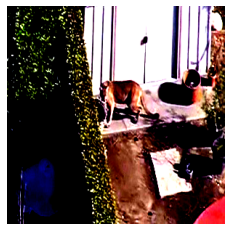

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cougar
tf.Tensor(
[[b'Open']
 [b'Read']
 [b'Map']], shape=(3, 1), dtype=string) tf.Tensor(
[[-1.0000000e+00 -1.0000000e+00]
 [ 1.2318141e+03  4.9880999e-03]
 [ 1.1781526e+03  4.0149901e-02]], shape=(3, 2), dtype=float32) tf.Tensor(
[[   2    0   -1]
 [   2    0 3291]
 [   2    0   -1]], shape=(3, 3), dtype=int32)
(300, 300, 3)


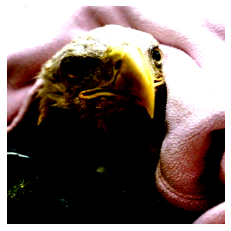

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bald_eagle
tf.Tensor(
[[b'Open']
 [b'Read']
 [b'Map']], shape=(3, 1), dtype=string) tf.Tensor(
[[-1.0000000e+00 -1.0000000e+00]
 [ 1.2052810e+03  9.6933004e-03]
 [ 1.1781526e+03  4.0149901e-02]], shape=(3, 2), dtype=float32) tf.Tensor(
[[   2    0   -1]
 [   2    0 1648]
 [   2    0   -1]], shape=(3, 3), dtype=int32)
(300, 300, 3)


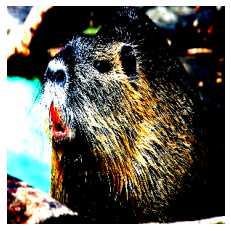

nutria


In [29]:
for steps, timings, counters, img, label in dataset_train_augmentation.take(3):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

## load weights wild_model.h5

In [23]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation)

training:


716it [06:00,  1.98it/s]                                                                                               


validating:


 99%|█████████████████████████████████████████████████████████████████████████████████ | 89/90 [00:34<00:00,  2.58it/s]


Epoch 1, Loss: 1.9894, Accuracy: 66.2622, val Loss: 0.3579, val Accuracy: 89.4663
training:


716it [05:32,  2.15it/s]                                                                                               


validating:


 99%|█████████████████████████████████████████████████████████████████████████████████ | 89/90 [00:26<00:00,  3.33it/s]


Epoch 2, Loss: 0.5505, Accuracy: 84.2179, val Loss: 0.2422, val Accuracy: 92.4157
training:


716it [05:48,  2.05it/s]                                                                                               


validating:


 99%|█████████████████████████████████████████████████████████████████████████████████ | 89/90 [00:27<00:00,  3.26it/s]

Epoch 3, Loss: 0.4915, Accuracy: 87.2905, val Loss: 0.2360, val Accuracy: 92.5562
Execution time: 1130.6460062


### 1st running

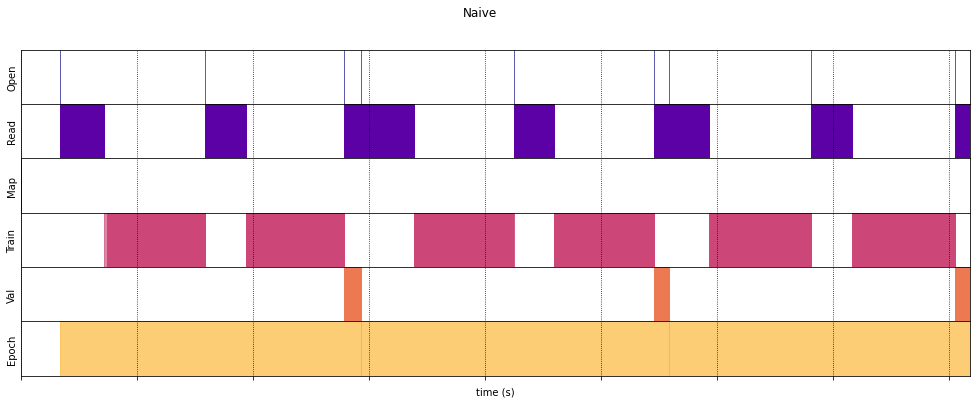

In [26]:
draw_timeline(timeline_Augmentation, "Naive", 500)

### 2nd running

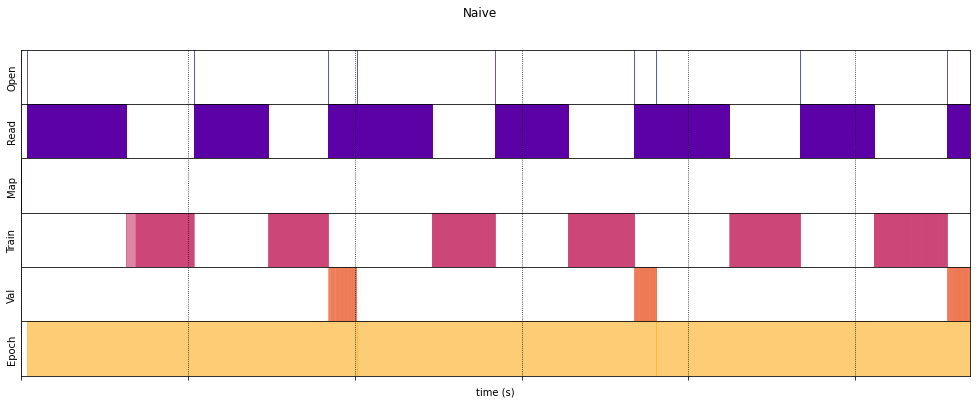

In [26]:
draw_timeline(timeline_Augmentation, "Naive", 500)

## Retrain your model with optimized terms, compare the time consuming.

In [27]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 16

In [13]:
# read data
def unpickle(file):
    with open(file, 'rb') as fo:
        raw_data = pickle.load(fo, encoding='bytes')
    return raw_data[b'data'],raw_data[b'labels']

In [14]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string),
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32),
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )


    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        
        rows = pd.read_csv(filename.decode("utf-8"))
        img_paths = rows['img_path'].tolist()
        labels = rows['label'].tolist()
        
        open_elapsed = time.perf_counter() - open_enter

        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = load_image(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                labels[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [15]:
@tf.function
def dataset_map_train(steps, times, values, img, label):
    #distorted_img = tf.image.random_crop(img, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    map_enter = time.perf_counter()
    distorted_img = tf.image.random_flip_left_right(img)
    distorted_img = tf.image.random_brightness(distorted_img, max_delta=63)
    distorted_img = tf.image.random_contrast(
    distorted_img, lower=0.2, upper=1.8)
    distorted_img = tf.image.per_image_standardization(distorted_img)
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_img,\
           label

def dataset_map_val(steps, times, values, img, label):
    map_enter = time.perf_counter()
    #distorted_img = tf.image.random_flip_left_right(img)
    #distorted_img = tf.image.random_brightness(distorted_img, max_delta=63)
    #distorted_img = tf.image.random_contrast(
    #distorted_img, lower=0.2, upper=1.8)
    distorted_img = tf.image.per_image_standardization(img)
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_img,\
           label

In [16]:
base_model_op = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model_op.layers:
    layer.trainable = False

top_model_op = models.Sequential()
top_model_op.add(layers.Flatten())
top_model_op.add(layers.Dense(4096, activation='relu'))
top_model_op.add(layers.Dropout(0.5))
top_model_op.add(layers.Dense(1024, activation='relu'))
top_model_op.add(layers.Dropout(0.5))
top_model_op.add(layers.Dense(n_classes, activation='softmax'))

wild_model_op = tf.keras.Model(inputs=base_model_op.input, outputs=top_model_op(base_model_op.output))

In [17]:
# save the initialization of weights 
wild_model_op.save_weights('wild_model_op.h5')

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [19]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = wild_model_op(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, wild_model_op.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model_op.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def val_step(images, labels):
    predictions = wild_model_op(images, training=False)
    v_loss = loss_object(labels, predictions)

    val_loss(v_loss)
    val_accuracy(labels, predictions)

In [20]:
def timelined_benchmark(dataset_train, dataset_test):
    EPOCHS = 3

    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        print("training:")
        for steps, times, values, images, labels in tqdm(dataset_train, total=math.ceil(len(img_path_train)/BATCH_SIZE)):
            for i in range(steps.shape[0]):
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            train_enter = time.perf_counter()
            train_step(images, labels)
            train_elapsed = time.perf_counter() - train_enter

            for i in range(steps.shape[0]):        
                steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
                times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        print("validating:")
        for steps, times, values, images, labels in tqdm(dataset_test, total=math.ceil(len(img_path_val)/BATCH_SIZE)):
            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            val_enter = time.perf_counter()
            val_step(images, labels)
            val_elapsed = time.perf_counter() - val_enter

            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, [["Val"]]), axis=0)
                times_acc = tf.concat((times_acc, [(val_enter, val_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, val Loss: {:.4f}, val Accuracy: {:.4f}'
        print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               val_loss.result(),
                               val_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch, -1]]), axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [21]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()

    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)

    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)

    order = [b'Open', b'Read', b'Map', b'Train', b'Val', b'Test', b'Epoch']
    step_ids = sorted(step_ids, key=lambda i: order.index(i))
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")

        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]

        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

In [24]:
dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .repeat(PEPEAT_COUNT)\
                                                  .map(dataset_map_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)

dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_val, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .batch(BATCH_SIZE, drop_remainder=True)\
                                                 .map(dataset_map_val, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .cache()\
                                                 .prefetch(tf.data.AUTOTUNE)

In [25]:
wild_model_op.load_weights('wild_model_op.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized)

training:


716it [05:16,  2.27it/s]                                                                                               


validating:


 99%|█████████████████████████████████████████████████████████████████████████████████ | 89/90 [00:32<00:00,  2.72it/s]


Epoch 1, Loss: 1.9435, Accuracy: 65.8258, val Loss: 0.3516, val Accuracy: 89.5365
training:


716it [02:35,  4.59it/s]                                                                                               


validating:


 99%|█████████████████████████████████████████████████████████████████████████████████ | 89/90 [00:18<00:00,  4.86it/s]


Epoch 2, Loss: 0.5758, Accuracy: 83.9647, val Loss: 0.2553, val Accuracy: 92.2051
training:


716it [02:50,  4.19it/s]                                                                                               


validating:


 99%|█████████████████████████████████████████████████████████████████████████████████ | 89/90 [00:18<00:00,  4.74it/s]

Epoch 3, Loss: 0.4565, Accuracy: 88.3642, val Loss: 0.2685, val Accuracy: 92.0646
Execution time: 712.8786776999999


### 1st running

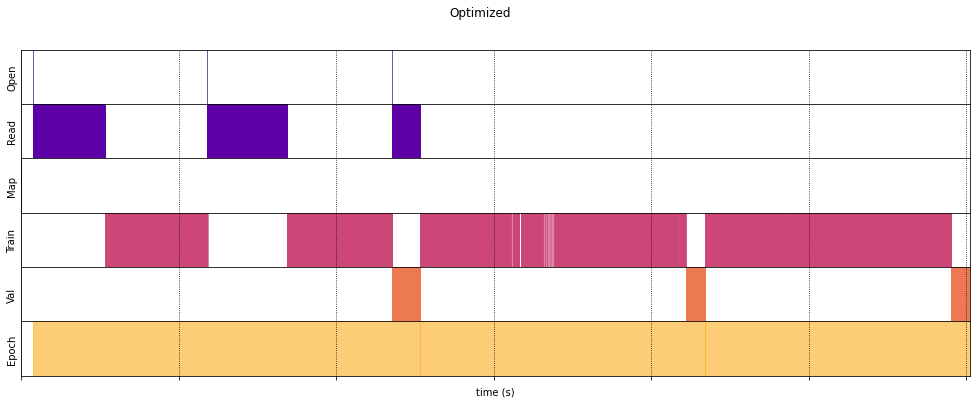

In [49]:
draw_timeline(timeline_Optimized, "Optimized", 500)

### 2nd running

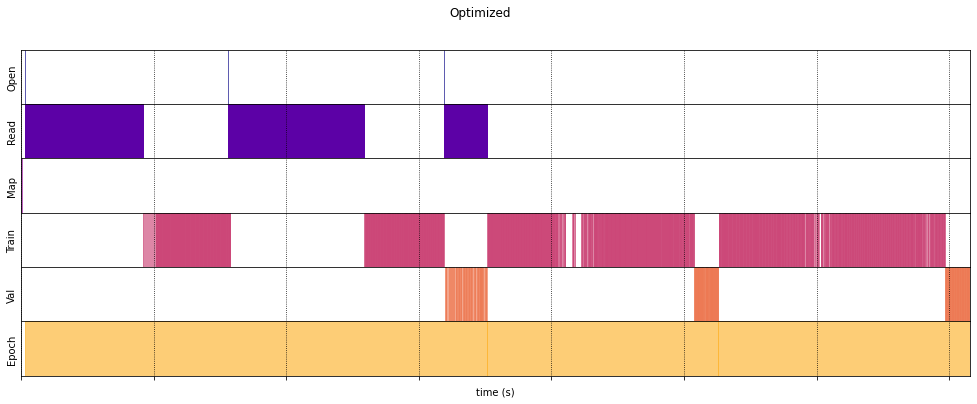

In [26]:
draw_timeline(timeline_Optimized, "Optimized", 500)

## Briefly summarize what you did and explain the performance results (accuracy and time consuming).

#### Transformation
* random_flip_left_right
* random_brightness
* random_contrast
* per_image_standardization

#### Shuffle

#### Batch

BATCH SIZE = 16

#### Repeat

#### Timing Optimization

prefetch, cache, num_parallel_calls

### After transformation, accuracy enhances
acc:11.5063
acc:10.6695
acc:10.3905

became

acc:89.4663
acc:92.4157
acc:92.5562

### After optimization, the model gets better efficiency

Execution time: 1130.6460062

become

Execution time: 712.8786776999999